In [ ]:
!pip install transformers

In [3]:
!pip install datasets

In [4]:
import datasets
from execution import training, evaluation
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
dataset = datasets.load_dataset('tweets_hate_speech_detection')
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 31962
    })
})


In [7]:
labels = dataset['train']['label']
tweets = dataset['train']['tweet']

In [8]:
tweets_train_val, tweets_test, labels_train_val, labels_test = train_test_split(tweets, labels, test_size=0.3)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Max sentence length:  383


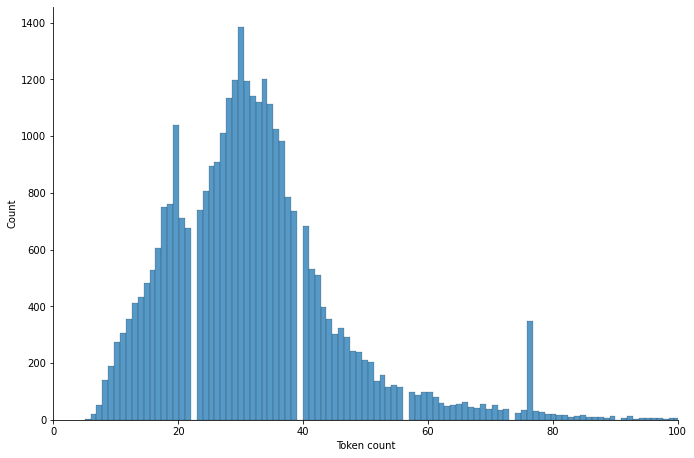

In [43]:
# Визуализация дли предложений с целью выбора максимальной длины
import seaborn as sns
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

token_lens = []
for txt in tweets:
    tokens = tokenizer.encode(txt)
    token_lens.append(len(tokens))
    
print('Max sentence length: ', max(token_lens))

sns.displot(token_lens, height=6.27, aspect=9.7/6.27)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [9]:
MAX_LEN = 80
BATCH_SIZE = 32
EPOCHS = 3
EVAL_STEP = 100
FOLDER = 'roberta_result'

### Обучение

In [10]:
training(tweets=tweets_train_val, 
         labels=labels_train_val,
         file_path=FOLDER,
         max_len=MAX_LEN,
         eval_step=EVAL_STEP, 
         epochs=EPOCHS, 
         batch_size=BATCH_SIZE)

INFO:root:Данные для обучения обработаны
INFO:root:Начато обучение модели


epoch 1/3, step 100/1470, train loss: 0.2205, valid loss: 0.1338
epoch 1/3, step 200/1470, train loss: 0.1387, valid loss: 0.1141
epoch 1/3, step 300/1470, train loss: 0.0975, valid loss: 0.0906
epoch 1/3, step 400/1470, train loss: 0.1119, valid loss: 0.0917
epoch 2/3, step 500/1470, train loss: 0.0845, valid loss: 0.0852
epoch 2/3, step 600/1470, train loss: 0.0854, valid loss: 0.0912
epoch 2/3, step 700/1470, train loss: 0.0668, valid loss: 0.0775
epoch 2/3, step 800/1470, train loss: 0.0648, valid loss: 0.0764
epoch 2/3, step 900/1470, train loss: 0.0655, valid loss: 0.0757
epoch 3/3, step 1000/1470, train loss: 0.0628, valid loss: 0.0917
epoch 3/3, step 1100/1470, train loss: 0.0399, valid loss: 0.0706
epoch 3/3, step 1200/1470, train loss: 0.0438, valid loss: 0.0762
epoch 3/3, step 1300/1470, train loss: 0.0468, valid loss: 0.0841
epoch 3/3, step 1400/1470, train loss: 0.0452, valid loss: 0.0781


INFO:root:Обучение завершено


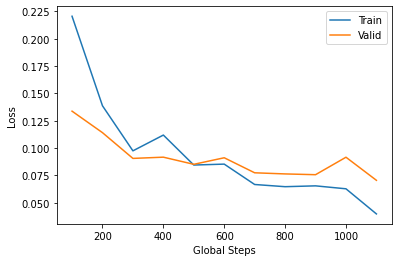

In [11]:
from save_load import load_metrics

train_loss_list, valid_loss_list, global_steps_list = load_metrics(FOLDER + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

### Предсказание

In [12]:
# исходная модель
outputs_base = evaluation(tweets=tweets_test,
                         labels=labels_test,
                         max_len=MAX_LEN,
                         batch_size=BATCH_SIZE)

print('Время на всю работу: {:.0f}m {:.0f}s'.format(outputs_base['all_time'] // 60, outputs_base['all_time'] % 60))
labels_base = outputs_base['labels_true']
pred_base = outputs_base['labels_pred']

INFO:root:Данные для предсказания обработаны
INFO:root:Предсказание завершено


Время на всю работу: 0m 45s


In [13]:
# дообученная модель
outputs_tr = evaluation(file_path=FOLDER,
                         tweets=tweets_test,
                         labels=labels_test,
                         max_len=MAX_LEN,
                         batch_size=BATCH_SIZE)

print('Время на всю работу: {:.0f}m {:.0f}s'.format(outputs_tr['all_time'] // 60, outputs_tr['all_time'] % 60))
labels_tr = outputs_tr['labels_true']
pred_tr = outputs_tr['labels_pred']

INFO:root:Данные для предсказания обработаны
INFO:root:Предсказание завершено


Время на всю работу: 0m 44s


In [14]:
import torch
path = 'metrics_test.pt'

def save_test(save_path, labels_true, labels_pred):
    state_dict = {'labels_true': labels_true,
                  'labels_pred': labels_pred}
    torch.save(state_dict, save_path)

In [15]:
def load_test(load_path):
    state_dict = torch.load(load_path, map_location=device)
    return state_dict['labels_true'], state_dict['labels_pred']

In [16]:
save_test(path, labels_tr, pred_tr)

### Оценка качества

In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import numpy as np 

In [18]:
y_pred_base = np.argmax(pred_base, axis=1)
y_pred_tr = np.argmax(pred_tr, axis=1)

In [19]:
acc_score_base = accuracy_score(labels_base, y_pred_base)
acc_score_tr = accuracy_score(labels_tr, y_pred_tr)
print('Точность базовой модели на тестовой выборке составила: {0:.2f}%'.format(acc_score_base*100))
print('Точность дообученной модели на тестовой выборке составила: {0:.2f}%'.format(acc_score_tr*100))

Точность базовой модели на тестовой выборке составила: 97.56%
Точность дообученной модели на тестовой выборке составила: 97.92%


**Вывод**

Точности на обеих моделя пратически совпадают. Дообученная модель увеличивает точность на тестовой выборке на 0.4%.

### PR-curve

In [20]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

pred_proba = sigmoid(np.array(pred_tr))[:,1]

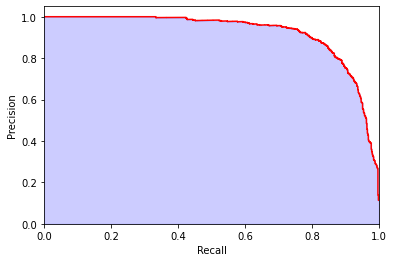

In [21]:
precision, recall, thresholds = precision_recall_curve(labels_tr, pred_proba)

fig, ax = plt.subplots()
ax.step(recall,precision,color='r',alpha=0.99,where='post')
ax.fill_between(recall, precision, alpha=0.2, color='b', step='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0]);

**Вывод**

Для использованного набора параметров была построена PR-кривая, которая характеризует соотношение метрик precision и recall для различных значений порога (threshold).

С увеличением значения порога увеличивается precision, но падает recall.


Так как расистские высказывания оскарбляют людей, а также разжигают конфликты, при выборе порога классификации необходимо уделять показателю Recall дополнительное внимание (вероятно лучше перестраховаться и пометить твит расистким, чем обидеть множество людей).
 

При выборе наибольшей вероятности при распределении по классам (порог 0.5) в данной задаче precision и recall:

In [22]:
precis, rec, _, _ = precision_recall_fscore_support(labels_tr, y_pred_tr, average='binary')
print(precis, rec)

0.8820826952526799 0.8252148997134671


В данном случае оба показателя являются достаточно высокими, но если мы хотим увеличить recall, например, до 0.84, то следует немного снизить threshold.

In [23]:
precision = precision[:-1]
recall = recall[:-1] 

In [24]:
result = np.hstack((precision.reshape(-1,1),
                    recall.reshape(-1,1), 
                    thresholds.reshape(-1,1)))

In [37]:
# precision, recall, thresholds
result[result[:,1] > 0.84][-1]

array([0.86450663, 0.84097421, 0.44495356])

Таким образом, можно понизить threshold до 0.44.

In [38]:
threshold = 0.44
new_pred = (pred_proba >= threshold)*1

precision и recall в данном случае равны:

In [39]:
precis, rec, _, _ = precision_recall_fscore_support(labels_tr, new_pred, average='binary')
print(precis, rec)

0.8621700879765396 0.8424068767908309


In [40]:
# точность остается той же
accuracy_score(labels_tr, new_pred)

0.9787256231098134